Goals of this notebook. Take our best model file:

* plot weights
* look at number of parameters
* check saturation of norms

In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


At the time of writing our best model is defined by the run settings file `alexnet_based_40aug.json`, basically taking the AlexNet based architecture with an extra convolutional layer and using more augmentation. Full details are in the following YAML file:

In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [3]:
cat yaml_templates/alexnet_based_extra_convlayer.yaml

!obj:pylearn2.train.Train {
    dataset: &train !obj:neukrill_net.dense_dataset.DensePNGDataset {
        settings_path: %(settings_path)s,
        run_settings: %(run_settings_path)s,
        training_set_mode: "train"
    },
    model: !obj:pylearn2.models.mlp.MLP {
        batch_size: &batch_size 128,
        input_space: !obj:pylearn2.space.Conv2DSpace {
            shape: %(final_shape)s,
            num_channels: 1,
            axes: ['c', 0, 1, 'b'],
        },
        layers: [ !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h1,
                     output_channels: 48,
                     irange: .025,
                     init_bias: 0,
                     kernel_shape: [8, 8],
                     pool_shape: [2, 2],
                     pool_stride: [2, 2],
                     max_kernel_norm: 1.9365
                 },!obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h2,
                     output_channels: 9

It has relatively few MLP layers, so maybe we should look at where the parameters in our model are distributed; comparing the MLP layers to the convolutional ones.

In [4]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/quicker_learning_1_fc_layer_experiment_no_norms_repeat.json", settings, force=True)

In [5]:
model = pylearn2.utils.serial.load(run_settings["pickle abspath"])

In [6]:
params = model.get_params()

In [7]:
params[0].name

'h1_W'

In [8]:
total_params = sum(map(lambda x: x.get_value().size,params))
print("Total parameters: {0}".format(total_params))

Total parameters: 48287340


In [9]:
for l in params:
    print("Layer {0}: {1} parameters".format(l.name,l.get_value().size))

Layer h1_W: 1200 parameters
Layer h1_b: 221952 parameters
Layer h2_W: 55296 parameters
Layer h2_b: 165888 parameters
Layer h3_W: 147456 parameters
Layer h3_b: 184832 parameters
Layer h4_W: 47316992 parameters
Layer h4_b: 1024 parameters
Layer softmax_b: 2 parameters
Layer softmax_W: 2048 parameters
Layer softmax_b: 4 parameters
Layer softmax_W: 4096 parameters
Layer softmax_b: 7 parameters
Layer softmax_W: 7168 parameters
Layer softmax_b: 16 parameters
Layer softmax_W: 16384 parameters
Layer softmax_b: 38 parameters
Layer softmax_W: 38912 parameters
Layer softmax_b: 121 parameters
Layer softmax_W: 123904 parameters


In [10]:
for l in params:
    print("Layer {0}: {1}% of the parameters.".format(l.name,
                        100*(float(l.get_value().size)/total_params)))

Layer h1_W: 0.00248512342987% of the parameters.
Layer h1_b: 0.459648429588% of the parameters.
Layer h2_W: 0.114514487648% of the parameters.
Layer h2_b: 0.343543462945% of the parameters.
Layer h3_W: 0.305371967062% of the parameters.
Layer h3_b: 0.382775278158% of the parameters.
Layer h4_W: 97.9904712084% of the parameters.
Layer h4_b: 0.00212063866015% of the parameters.
Layer softmax_b: 4.14187238311e-06% of the parameters.
Layer softmax_W: 0.00424127732031% of the parameters.
Layer softmax_b: 8.28374476623e-06% of the parameters.
Layer softmax_W: 0.00848255464062% of the parameters.
Layer softmax_b: 1.44965533409e-05% of the parameters.
Layer softmax_W: 0.0148444706211% of the parameters.
Layer softmax_b: 3.31349790649e-05% of the parameters.
Layer softmax_W: 0.0339302185625% of the parameters.
Layer softmax_b: 7.86955752792e-05% of the parameters.
Layer softmax_W: 0.0805842690859% of the parameters.
Layer softmax_b: 0.000250583279178% of the parameters.
Layer softmax_W: 0.25659

The reason we probably see little difference adding extra MLP layers is that the weight matrix leading into the first MLP layer is so much more massive than between the MLP layers themselves. Adding more MLP layers barely increases the number of parameters.

Receptive Fields/Kernels
========

Looking at the Kernels we've learnt using the script provided by Pylearn2.

In [11]:
%env PYLEARN2_VIEWER_COMMAND=/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/image_hack.sh

env: PYLEARN2_VIEWER_COMMAND=/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/image_hack.sh


In [12]:
%run ~/repos/pylearn2/pylearn2/scripts/show_weights.py /disk/scratch/neuroglycerin/models/quicker_learning_1_fc_layer_experiment_no_norms_repeat_recent.pkl

making weights report
loading model
loading done
smallest enc weight magnitude: 3.95500101149e-05
mean enc weight magnitude: 0.101006127894
max enc weight magnitude: 1.06396627426


In [13]:
from IPython.display import Image

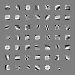

In [14]:
def plot_recent_pylearn2():
    pl2plt = Image(filename="/afs/inf.ed.ac.uk/user/s08/s0805516/tmp/pylearnplot.png", width=500)
    return pl2plt
plot_recent_pylearn2()

Trying to repeat this, but do it smarter, with holoviews.

In [16]:
weights = model.get_weights_topo()

HeatMap
      I       : HeatMap.HeatMap   (z)
      II      : HeatMap.HeatMap   (z)
      III     : HeatMap.HeatMap   (z)
      IV      : HeatMap.HeatMap   (z)
      V       : HeatMap.HeatMap   (z)
      VI      : HeatMap.HeatMap   (z)
      VII     : HeatMap.HeatMap   (z)
      VIII    : HeatMap.HeatMap   (z)
      IX      : HeatMap.HeatMap   (z)
      X       : HeatMap.HeatMap   (z)
      XI      : HeatMap.HeatMap   (z)
      XII     : HeatMap.HeatMap   (z)
      XIII    : HeatMap.HeatMap   (z)
      XIV     : HeatMap.HeatMap   (z)
      XV      : HeatMap.HeatMap   (z)
      XVI     : HeatMap.HeatMap   (z)
      XVII    : HeatMap.HeatMap   (z)
      XVIII   : HeatMap.HeatMap   (z)
      XIX     : HeatMap.HeatMap   (z)
      XX      : HeatMap.HeatMap   (z)
      XXI     : HeatMap.HeatMap   (z)
      XXII    : HeatMap.HeatMap   (z)
      XXIII   : HeatMap.HeatMap   (z)
      XXIV    : HeatMap.HeatMap   (z)
      XXV     : HeatMap.HeatMap   (z)
      XXVI    : HeatMap.HeatMap   (z)
      XXVII   : HeatMap.HeatMap   (z)
      XXVIII  : HeatMap.HeatMap   (z)
      XXIX    : HeatMap.HeatMap   (z)
      XXX     : HeatMap.HeatMap   (z)
      XXXI    : HeatMap.HeatMap   (z)
      XXXII   : HeatMap.HeatMap   (z)
      XXXIII  : HeatMap.HeatMap   (z)
      XXXIV   : HeatMap.HeatMap   (z)
      XXXV    : HeatMap.HeatMap   (z)
      XXXVI   : HeatMap.HeatMap   (z)
      XXXVII  : HeatMap.HeatMap   (z)
      XXXVIII : HeatMap.HeatMap   (z)
      XXXIX   : HeatMap.HeatMap   (z)
      XL      : HeatMap.HeatMap   (z)
      XLI     : HeatMap.HeatMap   (z)
      XLII    : HeatMap.HeatMap   (z)
      XLIII   : HeatMap.HeatMap   (z)
      XLIV    : HeatMap.HeatMap   (z)
      XLV     : HeatMap.HeatMap   (z)
      XLVI    : HeatMap.HeatMap   (z)
      XLVII   : HeatMap.HeatMap   (z)
      XLVIII  : HeatMap.HeatMap   (z)
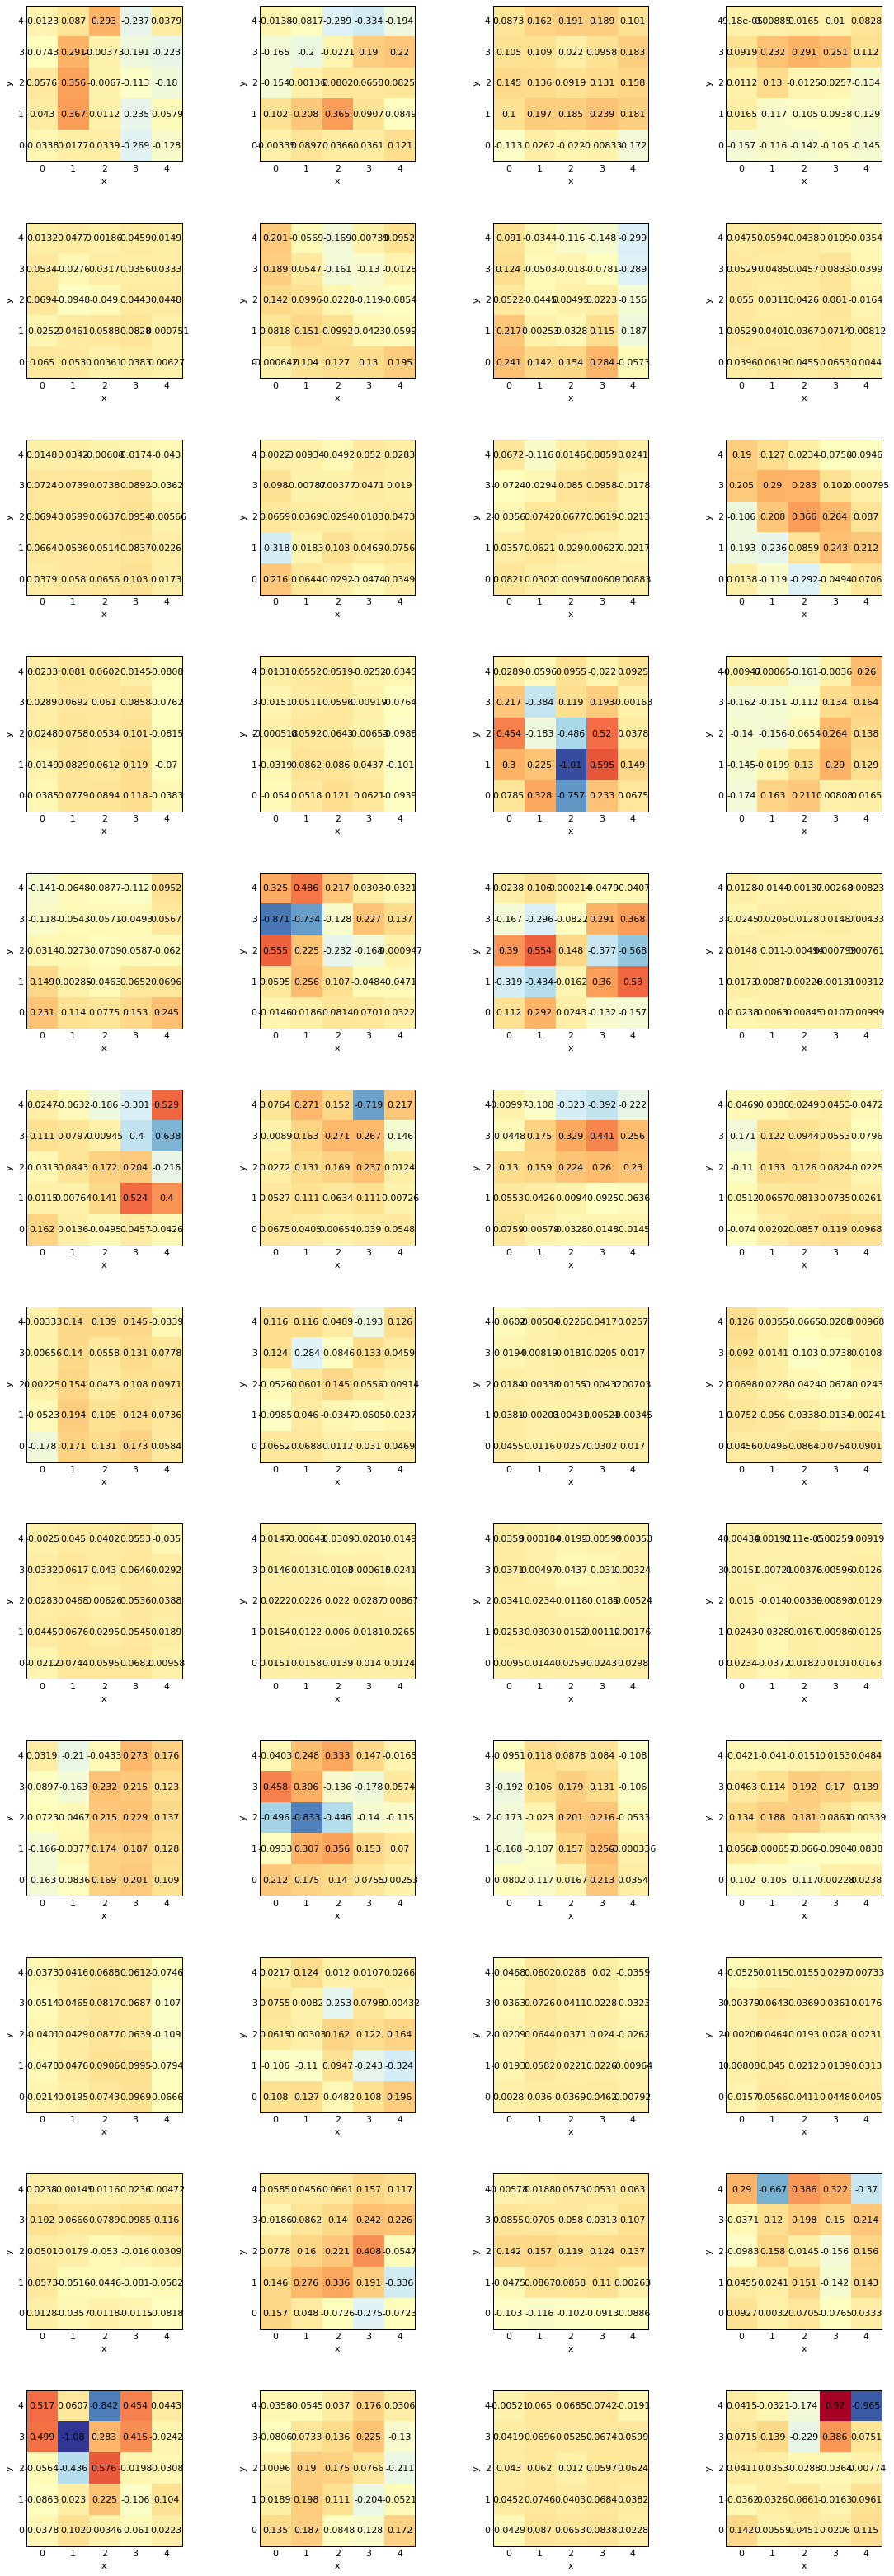

In [31]:
#%%opts HeatMap style(cmap='Greys')
heatmaps = None
for w in weights:
    w = {(i,j):w[i,j][0] for i in range(w.shape[0]) for j in range(w.shape[1])}
    if heatmaps == None:
        heatmaps = hl.HeatMap(w)
    else:
        heatmaps += hl.HeatMap(w)
heatmaps

In [121]:
maxes = []
for irange in np.logspace(-5,-0.5,50):
    W = ((np.random.rand(1000,5,5,1)*2)-1)*irange
    maxes.append(np.mean(np.sqrt(np.sum(W**2,axis=(1,2,3)))))

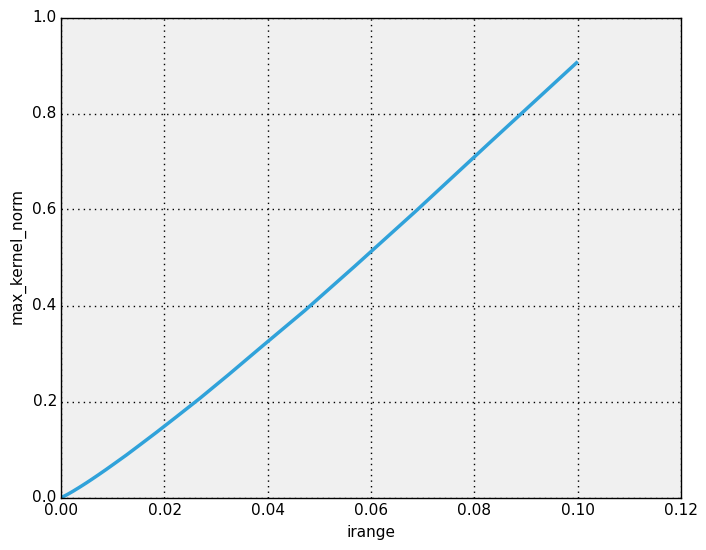

In [124]:
plt.xlabel("irange")
plt.ylabel("max_kernel_norm")
plt.plot(np.logspace(-5,-1,50),maxes)
plt.grid()

In [128]:
maxes = []
s = np.logspace(-4,-1,50)
for irange in s:
    W = ((np.random.rand(10,3,3,48)*2)-1)*irange
    maxes.append(np.mean(np.sqrt(np.sum(W**2,axis=(1,2,3)))))

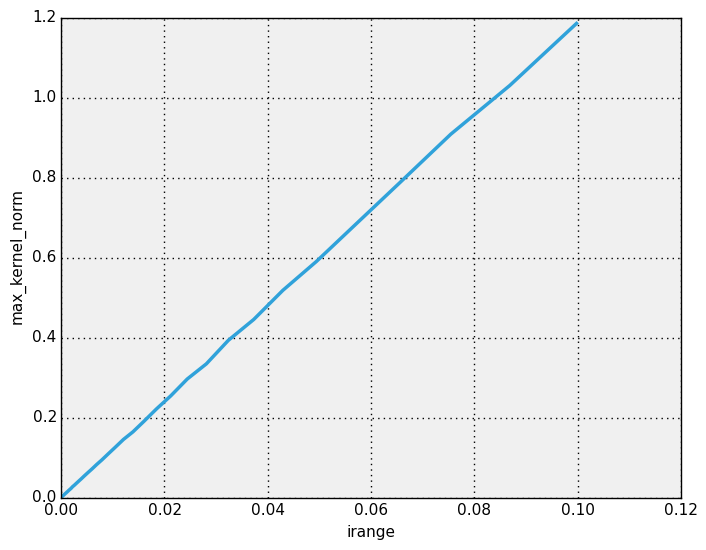

In [129]:
plt.xlabel("irange")
plt.ylabel("max_kernel_norm")
plt.plot(s,maxes)
plt.grid()

In [134]:
maxes = []
s = np.logspace(-4,-1.2,50)
for irange in s:
    W = ((np.random.rand(10,3,3,128)*2)-1)*irange
    maxes.append(np.mean(np.sqrt(np.sum(W**2,axis=(1,2,3)))))

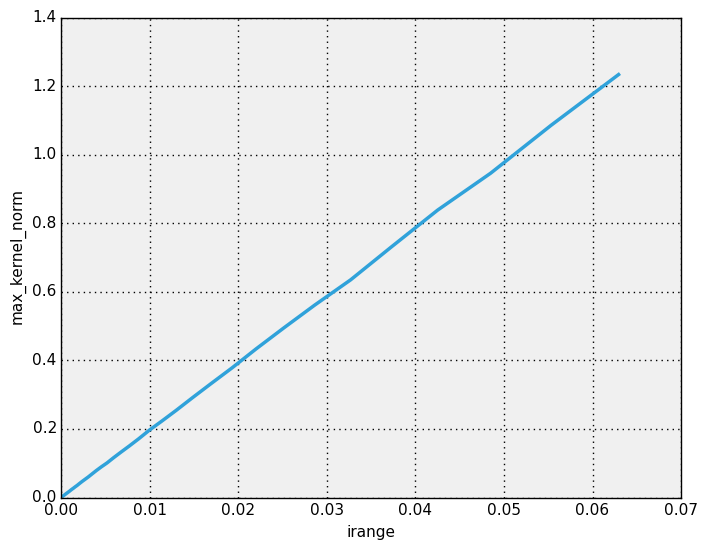

In [135]:
plt.xlabel("irange")
plt.ylabel("max_kernel_norm")
plt.plot(s,maxes)
plt.grid()

In [3]:
10*46208*1024

473169920

In [15]:
maxes = []
s = np.logspace(-5,-2,50)
for irange in s:
    W = np.random.randn(10,46208)*irange
    maxes.append(np.mean(np.sqrt(np.sum(W**2,axis=1))))

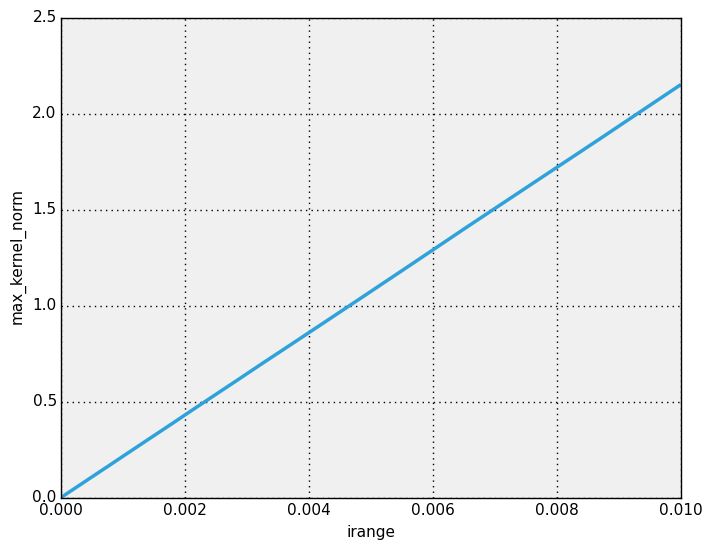

In [16]:
plt.xlabel("irange")
plt.ylabel("max_kernel_norm")
plt.plot(s,maxes)
plt.grid()

In [19]:
# MLP layer
maxnorm = 0
istdev = 0.0005
while maxnorm < 0.3:
    W = np.random.randn(1024,46208)*istdev
    maxnorm = np.mean(np.sqrt(np.sum(W**2,axis=1)))
    istdev = istdev*1.1
print("istdev should be approximately {0}".format(istdev))

istdev should be approximately 0.00156921418836
